In [397]:
#Importing Libraries

import os
os.environ["OMP_NUM_THREADS"] = "2"  # Set once to avoid sklearn KMeans warning

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.cluster import KMeans
import contextily as ctx
import folium
from folium.plugins import MarkerCluster




In [398]:
# Load Odisha village boundaries
url1 = "https://github.com/datameet/indian_village_boundaries/raw/master/or/or1.geojson"
url2 = "https://github.com/datameet/indian_village_boundaries/raw/master/or/or2.geojson"
gdf1 = gpd.read_file(url1)
gdf2 = gpd.read_file(url2)
gdf = pd.concat([gdf1, gdf2], ignore_index=True)

In [399]:
# Filter Ganjam district villages with valid geometry and district
gdf = gdf[gdf.geometry.notnull()]
gdf = gdf[gdf['DISTRICT'].notnull()]
ganjam = gdf[gdf['DISTRICT'].str.contains("Ganjam", case=False)].copy()

In [400]:
print(ganjam.columns)

Index(['SUB_DIST', 'DISTRICT', 'STATE', 'NAME', 'CEN_2001', 'TYPE',
       'geometry'],
      dtype='object')


In [401]:
ganjam.head

<bound method NDFrame.head of             SUB_DIST DISTRICT   STATE           NAME          CEN_2001  \
2313       Tarasingi   Ganjam  Odisha    Gunduribadi  2119000103051700   
2343          Jarada   Ganjam  Odisha     Lalkamagam  2119001903322700   
2344          Buguda   Ganjam  Odisha       Kusapali  2119000203063900   
2345       Tarasingi   Ganjam  Odisha     Narigochha  2119000103051400   
2391       Tarasingi   Ganjam  Odisha      Baradanda  2119000103054200   
...              ...      ...     ...            ...               ...   
49769         Jarada   Ganjam  Odisha      Abhayapur  2119001903318600   
49770         Jarada   Ganjam  Odisha     Koinphulia  2119001903330800   
49771         Jarada   Ganjam  Odisha        Nuagada  2119001903322800   
49772         Jarada   Ganjam  Odisha       Bhimapur  2119001903322200   
49773  Golanthara(p)   Ganjam  Odisha  Dayanidhipeta  2119001603269300   

          TYPE                                           geometry  
2313   Villag

In [402]:
ganjam = ganjam.drop_duplicates()

In [403]:
ganjam['DISTRICT'] = ganjam['DISTRICT'].str.strip().str.title()

In [404]:
ganjam = ganjam.dropna(subset=['NAME'])

In [405]:
ganjam_dissolved = ganjam.dissolve(by='SUB_DIST')

In [406]:
# Project for centroid calculation and revert to lat/lon
ganjam_proj = ganjam.to_crs(epsg=3857)
centroids_proj = ganjam_proj.geometry.centroid
centroids = centroids_proj.to_crs(epsg=4326)
ganjam['lon'] = centroids.x
ganjam['lat'] = centroids.y

In [407]:
# Filter valid geometries
ganjam_proj = ganjam_proj[ganjam_proj.is_valid]

In [408]:
# Filter out polygons with zero area
ganjam_proj = ganjam_proj[ganjam_proj.area > 0]

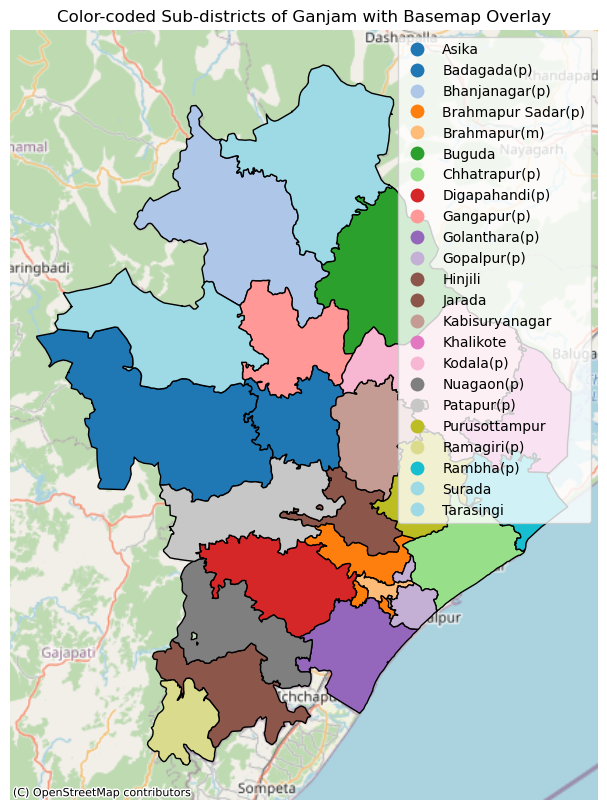

In [409]:

ganjam_subdistrict = ganjam.dissolve(by='SUB_DIST')
ganjam_subdistrict = ganjam_subdistrict.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))
ganjam_subdistrict.plot(column=ganjam_subdistrict.index,
                        cmap='tab20',
                        legend=True,
                        edgecolor='black',
                        ax=ax)

# Use OpenStreetMap tiles instead of Stamen
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Color-coded Sub-districts of Ganjam with Basemap Overlay')
plt.axis('off')
plt.show()

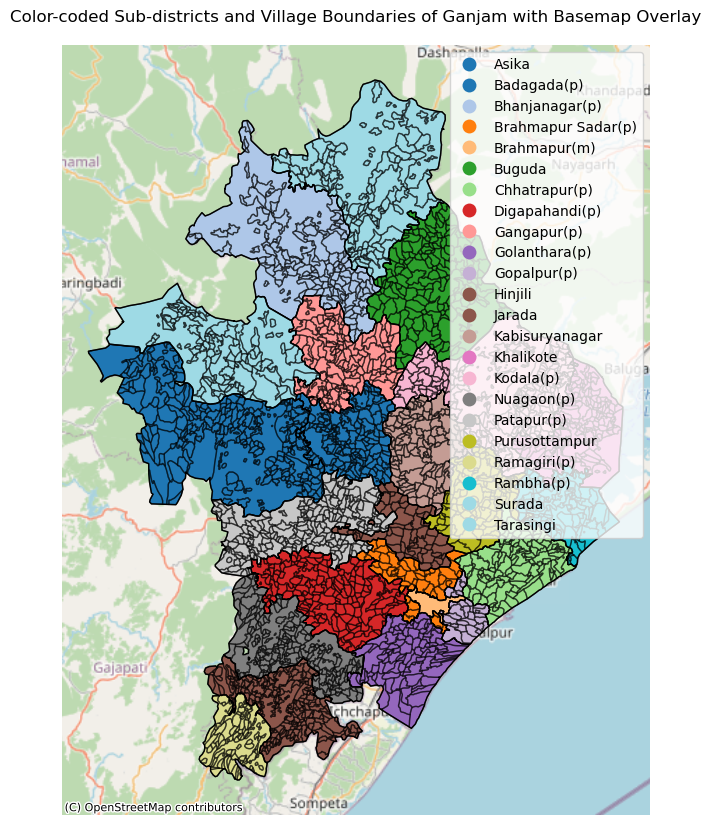

In [410]:

# Dissolve by sub-district
ganjam_subdistrict = ganjam.dissolve(by='SUB_DIST')

# Reproject both to web mercator
ganjam_subdistrict = ganjam_subdistrict.to_crs(epsg=3857)
ganjam_villages = ganjam.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot dissolved subdistricts with colors
ganjam_subdistrict.plot(column=ganjam_subdistrict.index,
                        cmap='tab20',
                        legend=True,
                        edgecolor='black',
                        ax=ax)

# Plot village boundaries on top with partial transparency
ganjam_villages.plot(ax=ax, alpha=0.5, edgecolor='k', facecolor="none")

# Add basemap underneath
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Color-coded Sub-districts and Village Boundaries of Ganjam with Basemap Overlay')
plt.axis('off')
plt.show()


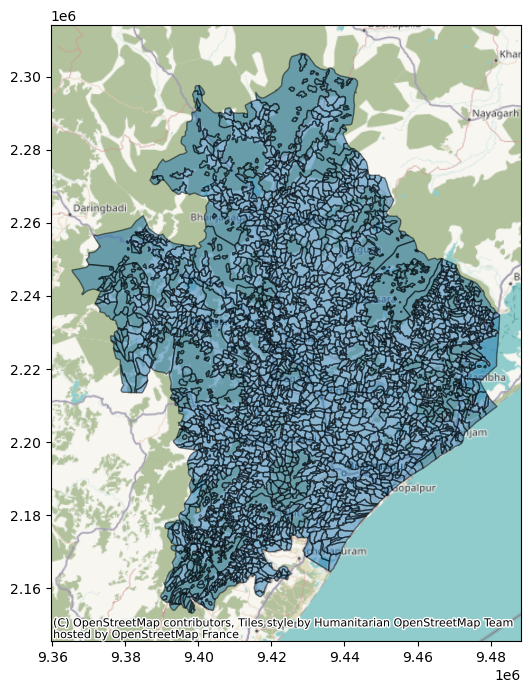

In [411]:

ax = ganjam.to_crs('EPSG:3857').plot(figsize=(10,8), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

<Axes: >

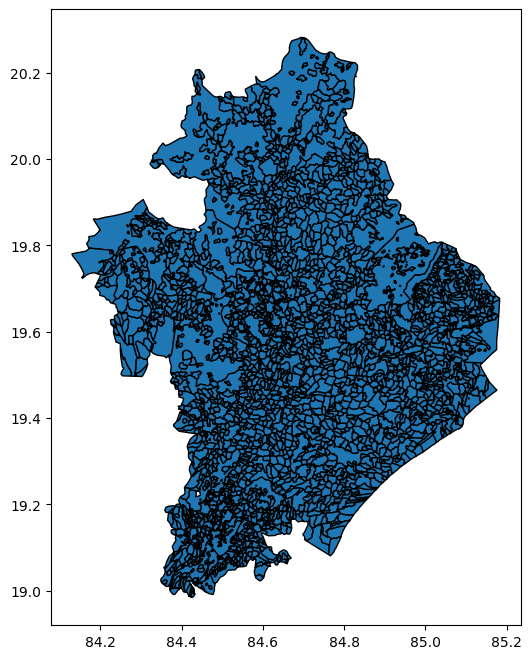

In [412]:
ganjam.plot(edgecolor='black', figsize=(10,8))

In [413]:
# Assign synthetic demand
np.random.seed(42)
ganjam['demand'] = np.random.randint(5, 20, size=len(ganjam))

sample_size = 500
subset = ganjam.sample(sample_size, random_state=42).reset_index(drop=True)

num_vehicles = 10  # number of clusters / vehicle routes

coords = subset[['lon', 'lat']].values
kmeans = KMeans(n_clusters=num_vehicles, random_state=42).fit(coords)
subset['cluster'] = kmeans.labels_

# Show cluster demand sums
cluster_demand = subset.groupby('cluster')['demand'].sum()
print("Cluster demands:\n", cluster_demand)


Cluster demands:
 cluster
0    947
1    463
2    606
3    489
4    634
5    368
6    626
7    920
8    463
9    491
Name: demand, dtype: int32


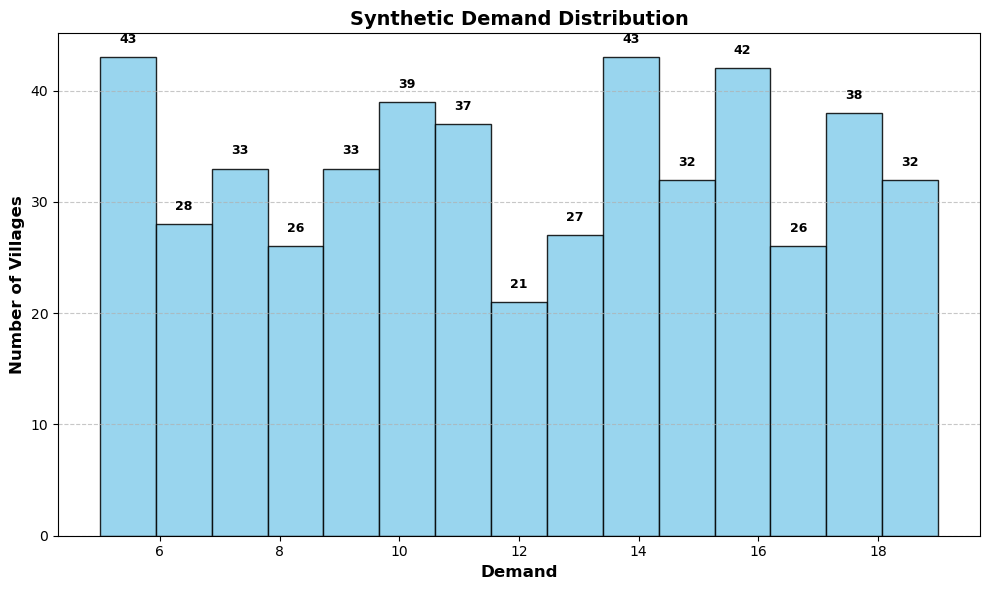

In [414]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(subset['demand'], bins=15, color='skyblue', edgecolor='black', alpha=0.85)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels on top of bars
for count, x in zip(n, bins):
    plt.text(x + (bins[1]-bins[0])/2, count + 1, str(int(count)), 
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel('Demand', fontsize=12, fontweight='bold')
plt.ylabel('Number of Villages', fontsize=12, fontweight='bold')
plt.title('Synthetic Demand Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


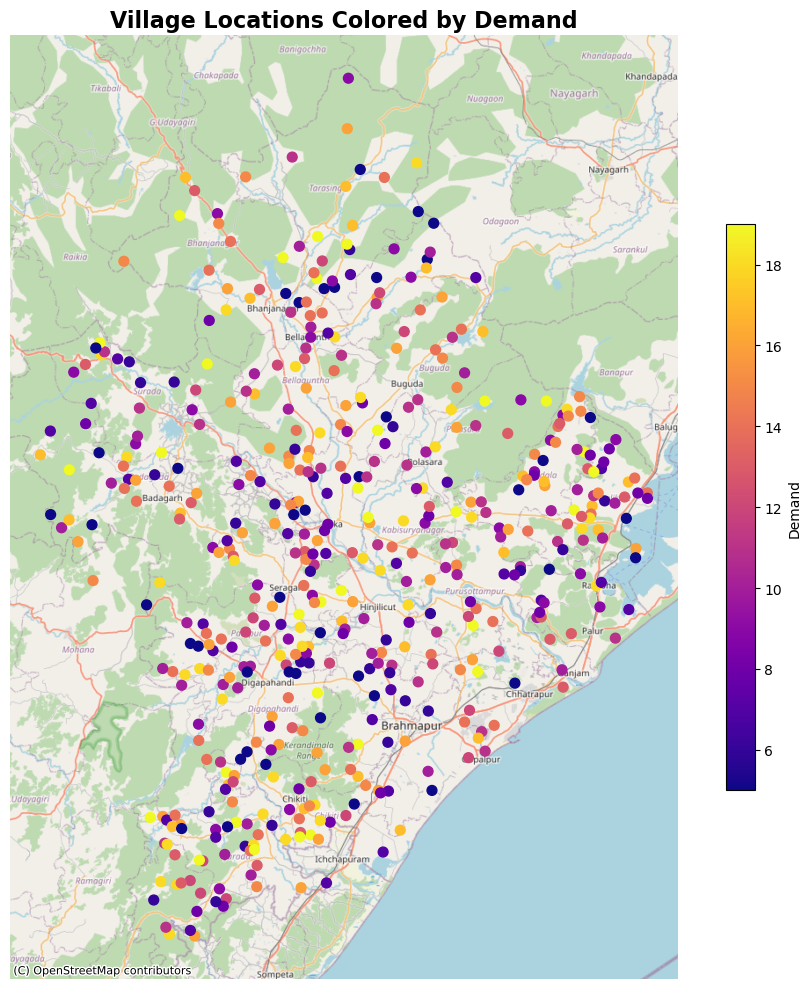

In [415]:
# Scatter plot colored by demand
# Convert subset to GeoDataFrame
gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset.lon, subset.lat))
gdf.crs = "EPSG:4326"  # Set coordinate system to WGS84 lat/lon
gdf = gdf.to_crs(epsg=3857)  # Web Mercator for contextily compatibility

# Plot with color mapped to demand
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         column='demand',
         cmap='plasma',
         markersize=50,
         legend=True,
         legend_kwds={'label': "Demand", 'shrink': 0.6})

# Add basemap under the points
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Styling
ax.set_axis_off()
ax.set_title('Village Locations Colored by Demand', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [416]:
def nearest_neighbor_route(points):
    points = points.copy()
    route = []
    current = points.iloc[0]
    route.append(current)
    points = points.drop(points.index[0])
    while not points.empty:
        dists = ((points['lon'] - current.lon)**2 + (points['lat'] - current.lat)**2).pow(0.5)
        idx = dists.idxmin()
        current = points.loc[idx]
        route.append(current)
        points = points.drop(idx)
    return pd.DataFrame(route)


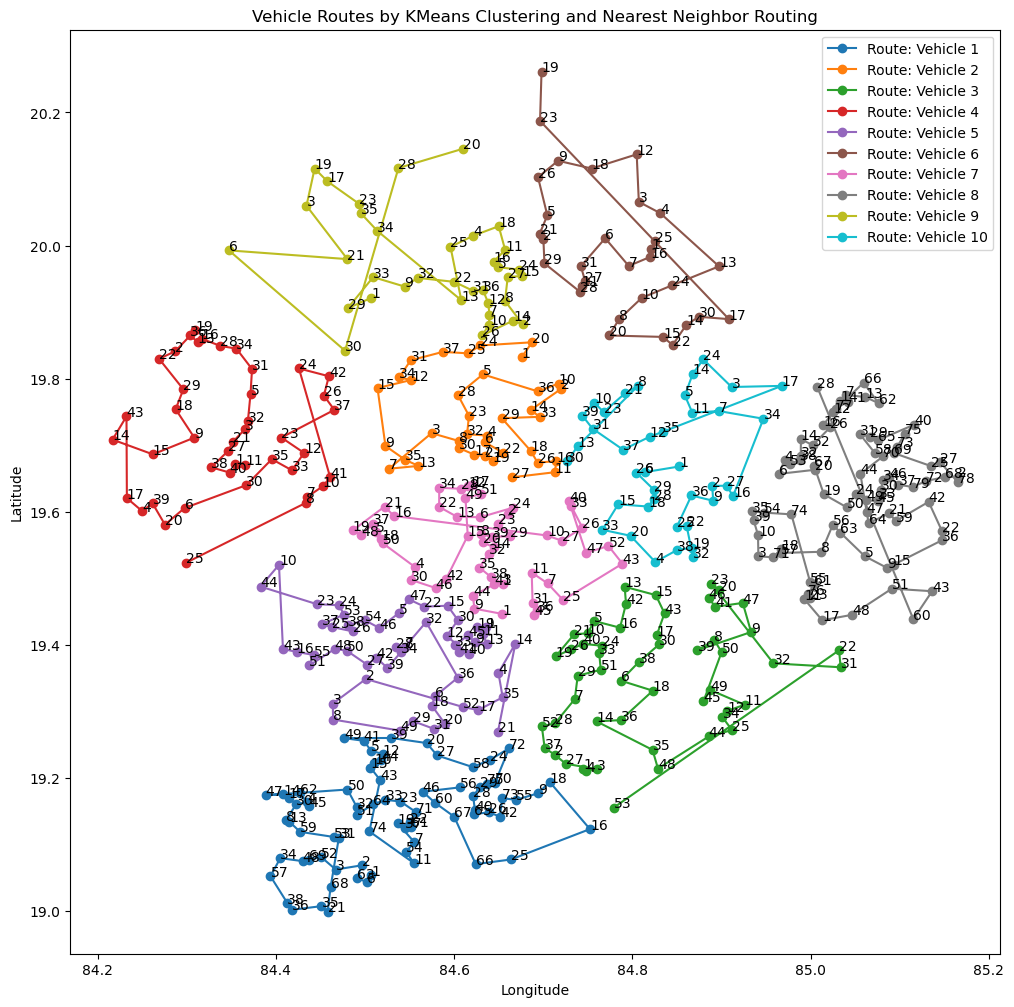

In [417]:
fig, ax = plt.subplots(figsize=(12, 12))
colors = plt.colormaps['tab10'].resampled(num_vehicles)

for cluster_id in range(num_vehicles):
    cluster_points = subset[subset['cluster'] == cluster_id]
    if cluster_points.empty:
        continue
    route_df = nearest_neighbor_route(cluster_points.reset_index(drop=True))
    ax.plot(route_df['lon'], route_df['lat'], color=colors(cluster_id), marker='o', label=f'Route: Vehicle {cluster_id + 1}')
    for i, row in route_df.iterrows():
        ax.annotate(i + 1, (row['lon'], row['lat']))

ax.set_title("Vehicle Routes by KMeans Clustering and Nearest Neighbor Routing")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [418]:

# Choose colormap for clusters
colors_folium = ['blue', 'green', 'red', 'purple', 'orange', 
                 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

# Initialize folium map centered at mean coordinates
m = folium.Map(location=[subset['lat'].mean(), subset['lon'].mean()], zoom_start=10)

# Add village points clustered by location with popups
marker_cluster = MarkerCluster().add_to(m)
for idx, row in subset.iterrows():
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=5,
        color=colors_folium[row['cluster'] % len(colors_folium)],
        fill=True,
        fill_opacity=0.8,
        popup=f"Village: {row['VILLAGE'] if 'VILLAGE' in subset.columns else idx} <br>Demand: {row['demand']} <br>Cluster: {row['cluster']}"
    ).add_to(marker_cluster)

# Compute routes per cluster using nearest neighbor and add polyline overlays
def nearest_neighbor_route(points):
    points = points.copy()
    route = []
    current = points.iloc[0]
    route.append(current)
    points = points.drop(points.index[0])
    while not points.empty:
        dists = ((points['lon'] - current.lon)**2 + (points['lat'] - current.lat)**2).pow(0.5)
        idx = dists.idxmin()
        current = points.loc[idx]
        route.append(current)
        points = points.drop(idx)
    return pd.DataFrame(route)

for cluster_id in range(num_vehicles):
    cluster_points = subset[subset['cluster'] == cluster_id].reset_index(drop=True)
    if cluster_points.empty:
        continue
    route_df = nearest_neighbor_route(cluster_points)
    route_coords = list(zip(route_df['lat'], route_df['lon']))
    
    folium.PolyLine(
        locations=route_coords,
        color=colors_folium[cluster_id % len(colors_folium)],
        weight=4,
        opacity=0.7,
        tooltip=f'Route Vehicle {cluster_id}'
    ).add_to(m)

# Display map in Jupyter
m


In [419]:
# Step 1: Determine label column for popup display

if 'VILLAGE' in subset.columns:
    name_col = 'VILLAGE'
elif 'name' in subset.columns:
    name_col = 'name'
else:
    name_col = None

# Step 2: Prepare routes dictionary for polyline drawing
# Assuming nearest_neighbor_route function is defined as:

def nearest_neighbor_route(points):
    points = points.copy()
    route = []
    current = points.iloc[0]
    route.append(current)
    points = points.drop(points.index[0])
    while not points.empty:
        dists = ((points['lon'] - current.lon)**2 + (points['lat'] - current.lat)**2).pow(0.5)
        idx = dists.idxmin()
        current = points.loc[idx]
        route.append(current)
        points = points.drop(idx)
    return pd.DataFrame(route)

routes = {}
for vehicle_id in range(num_vehicles):
    cluster_points = subset[subset['cluster'] == vehicle_id].reset_index()
    if cluster_points.empty:
        continue
    ordered_route = nearest_neighbor_route(cluster_points)
    # Map back to original subset indices for plotting on folium map
    original_indices = cluster_points.loc[ordered_route.index, 'index'].tolist()
    routes[vehicle_id] = original_indices

# Step 3: Create folium map centered on mean lat/lon
m = folium.Map(location=[subset['lat'].mean(), subset['lon'].mean()], zoom_start=10)
colors_folium = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']

# Step 4: Add CircleMarkers for each village
for idx, row in subset.iterrows():
    label_name = row[name_col] if name_col else idx
    folium.CircleMarker(
        location=(row['lat'], row['lon']),
        radius=4,
        color=colors_folium[row['cluster'] % len(colors_folium)],
        fill=True,
        fill_opacity=0.7,
        popup=f"{label_name} (Cluster {row['cluster']})"
    ).add_to(m)

# Step 5: Add route polylines per vehicle
for vehicle_id, route_indices in routes.items():
    route_coords = [(subset.loc[i, 'lat'], subset.loc[i, 'lon']) for i in route_indices]
    folium.PolyLine(
        locations=route_coords,
        color=colors_folium[vehicle_id % len(colors_folium)],
        weight=5,
        opacity=0.6,
        tooltip=f'Vehicle {vehicle_id} route'
    ).add_to(m)

# Step 6: Save map to HTML and display inline in notebook
m.save('ganjam_vehicle_routes_map.html')
print("Interactive vehicle route map saved to 'ganjam_vehicle_routes_map.html'")

from IPython.display import IFrame
IFrame('ganjam_vehicle_routes_map.html', width=800, height=600)


Interactive vehicle route map saved to 'ganjam_vehicle_routes_map.html'


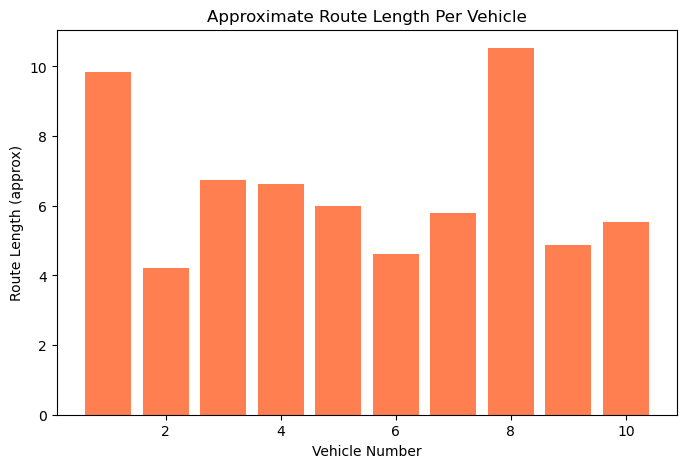

In [420]:
def route_length(points):
    total = 0
    for i in range(len(points)-1):
        total += sqrt((points.loc[i+1,'lon'] - points.loc[i,'lon'])**2 + (points.loc[i+1,'lat'] - points.loc[i,'lat'])**2)
    return total

route_lengths = []
for cluster_id in range(num_vehicles):
    cluster_points = subset[subset['cluster'] == cluster_id].reset_index(drop=True)
    route_df = nearest_neighbor_route(cluster_points)
    route_lengths.append(route_length(route_df))

plt.figure(figsize=(8,5))
plt.bar(range(1, num_vehicles + 1), route_lengths, color='coral')
plt.xlabel('Vehicle Number')
plt.ylabel('Route Length (approx)')
plt.title('Approximate Route Length Per Vehicle')
plt.show()
